In [1]:
import os
import pickle
from win32gui import FindWindow, SetForegroundWindow, GetClientRect, ClientToScreen
import pyautogui
import cv2
import numpy as np
import tensorflow as tf
import tkinter as tk
from PIL import Image, ImageTk
from threading import Thread
from ctypes import windll
from math import floor, ceil
import win32api
import time

In [2]:
SavedModel = os.path.dirname("YOU_PATH_TO_THE_FILE/Model-Color-UNET/weights/saved_model.pb")
Template_dir = r"YOU_PATH_TO_THE_FILE\Predictions.pickle"

PredImage = None
ImageTesten = None

StopKey = True
MouseDown = False

In [3]:
Template = pickle.load(open(Template_dir, "rb"))[40]

In [4]:
def screenshot(window_title=None, lenx=512, leny=512):
	im = pyautogui.screenshot(region=(1024, 464, 512, 512))
	gray = np.array(im)
	image = np.array(gray).reshape(-1, lenx, leny, 3)
	return image

In [5]:
def load_K14():
    model = tf.keras.models.load_model(SavedModel)

    configproto = tf.compat.v1.ConfigProto() 
    configproto.gpu_options.allow_growth = True
    sess = tf.compat.v1.Session(config=configproto) 
    tf.compat.v1.keras.backend.set_session(sess)
    return model

In [6]:
model = load_K14()

In [7]:
def xyz(image):
    im_preds = model.predict_on_batch(image)
    image = image.reshape(512, 512, 3)
    im_preds = tf.reshape(im_preds, [512, 512, 1]).numpy()
    return im_preds

In [8]:
def Coords(Pred, small):
	Pred = (255 - cv2.inRange(np.array(Pred * 255, dtype = np.uint8), 0, 160)).astype(np.float32)
	small = np.array(small * 255, dtype = np.uint8).astype(np.float32)
	result = cv2.matchTemplate(Pred, small, cv2.TM_SQDIFF_NORMED)
	mn,_,mnLoc,_ = cv2.minMaxLoc(result)
	MPx,MPy = mnLoc
	return (MPx+2-256, MPy+2-256)

In [9]:
class MouseTracker(Thread):
	def __init__(self):
		Thread.__init__(self)
		None
	def run(self):
		global StopKey, MouseDown
		while StopKey:
			MouseState = win32api.GetKeyState(0x01)
			if MouseState == -127 or MouseState == -128:  # Button state changed
				MouseDown = True
				state_left = MouseState
			else:
				MouseDown = False
			time.sleep(0.001)

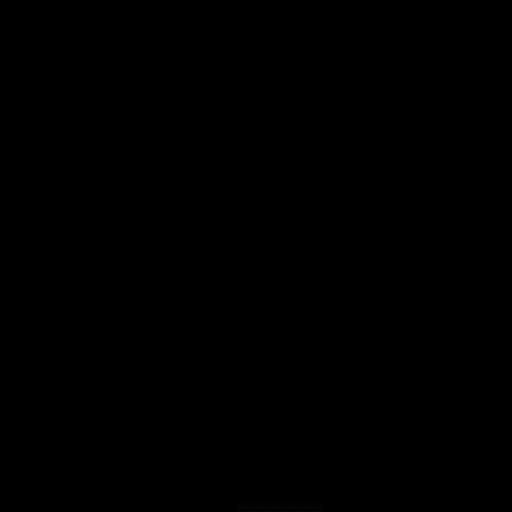

In [10]:
PredImage=xyz(screenshot())
Image.fromarray((cv2.cvtColor(PredImage,cv2.COLOR_GRAY2RGB) * 255).astype(np.uint8))

In [11]:
inst = MouseTracker()
inst.start()

In [12]:
time.sleep(5)

In [13]:
while True:
    if MouseDown:
        #t = time.time()
        PredImage=Coords(xyz(screenshot()), Template)
        windll.user32.mouse_event(0x0001, int(PredImage[0]*0.98), int(PredImage[1]*0.98), 0, 0)
        #print("-----------------------------", time.time()-t)

KeyboardInterrupt: 